torch.Size([16, 193])


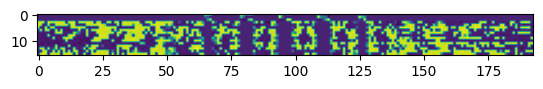

In [1]:
import os
# Select GPU setting
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import math
import scipy.io
import numpy as np
import torchvision.transforms as transforms

import torch
import torch.optim as optim

import datetime
import wandb
from torchsummary import summary
import RCAN_recon
import UNet_skip
import UNet
import Attention_GAN

from FPM_recon_dataset_RED import FPM_recon_dataset_RED
from FPM_dataset_RED import FPM_dataset_RED

import matplotlib.pyplot as plt

import time
import rcan_common as rcan_common
import discriminator
import imageio
import visualizer
from PIL import Image
import io
from utils import *

from skimage.exposure import match_histograms

IMAGE_SHAPE_INTER = (1, 600, 600)
baseDir="/home/kcl724/data/data3/KC/virtual_staining/"
save_weight_dir=baseDir+"weights/"
name_weight_recon='recon_20241113_114121_00400' ## w/o/ forward




# ## led 32
# nLED=32
# name_weight_recon='recon_20240627_020315_00400' ## w/o/ forward

# # ## led 16
nLED=16
name_weight_recon='recon_20240605_224330_00600' ## w/o/ forward

# # ## led 12
# nLED=12
# name_weight_recon='recon_20240626_145525_00400' ## w/o/ forward

# ## led 8
# nLED=8
# name_weight_recon='recon_20240626_004723_00400' ## w/o/ forward

## led 3
# nLED=3
# name_weight_recon='recon_20240625_101111_00400' ## w/o/ forward




TPARAMS = {}
TPARAMS['model_recon'] = RCAN_recon.RCAN_recon(IMAGE_SHAPE_INTER,3,nLED-3)
TPARAMS['model_recon'].load_state_dict(torch.load(save_weight_dir+'recon/'+name_weight_recon+'.pth'))
led_weights=TPARAMS['model_recon'].led_weights.clone().cpu().detach()
leds=TPARAMS['model_recon'].led_list# print(leds.shape)
TPARAMS['led_list'] = leds
print(led_weights.shape)

file_name='./leds/250204_led.mat'
scipy.io.savemat(file_name,{"led_weights":led_weights,"leds":leds})
# imageio.imwrite(saveDir+'stain/'+ 'stain_unstained_{0:03d}'.format(i)+'.png',(result_stain_unstained*256).astype(np.uint8))



# print(leds[0,:])

plt.imshow(led_weights)
plt.show()

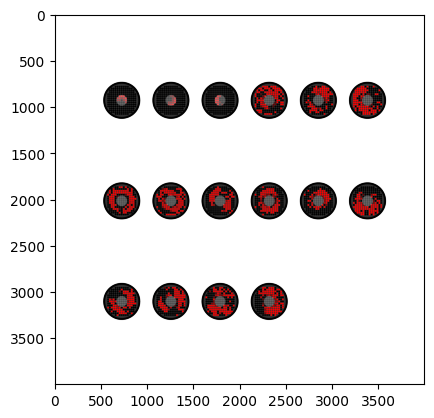

In [2]:

# print(TPARAMS)
parameters = TPARAMS
# parameters = TPARAMS['model_recon']

leds=led_visualize(parameters)
plt.figure()
plt.imshow(leds)
plt.show()

for i in range (nLED):
    leds=led_visualize_individual(parameters, i)
    # plt.imshow(leds)
    # plt.show()
    imageio.imwrite('./leds/'+ 'led_{0:03d}'.format(i)+'.png', leds)

(32, 32)


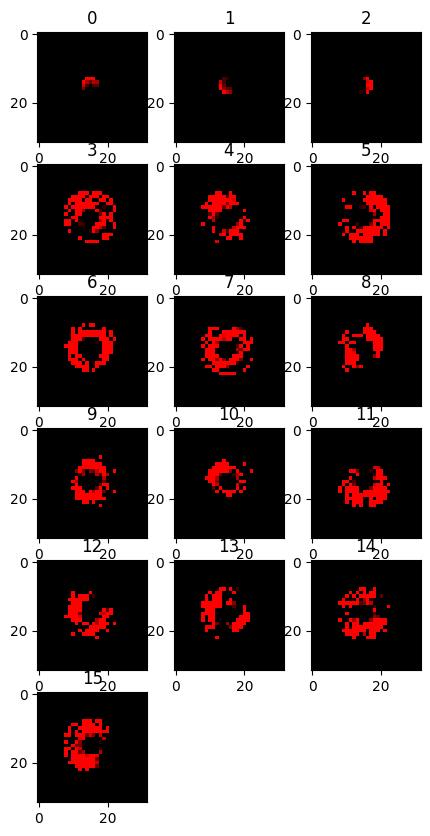

In [3]:
wavelength = 0.6e-6
arraySize_led = 32
ds_led = 4e-3
z_led = 80e-3
center_x = 16
center_y = 16
sampling_rad = 8
k0 = (2*np.pi/wavelength)
dpix_obj = 2.4e-6

## generate circular sampling pattern
grid_array=np.arange(1,arraySize_led+1)
rad_array_x,rad_array_y=np.meshgrid(grid_array,grid_array)
rad_array_x=rad_array_x-center_x
rad_array_y=rad_array_y-center_y

litCoord=(rad_array_x**2+rad_array_y**2)<sampling_rad**2
# litCoord=(np.abs(rad_array_x)<sampling_rad)*(np.abs(rad_array_y)<sampling_rad)
row,col=np.where(litCoord==1)

print(litCoord.shape)

litCoord_idx=np.zeros((32,32))
litCoord_weight=np.zeros((led_weights.shape[0],32,32))

led_weights = led_weights.clip(min = 0, max =1)
led_weights_init = led_weights
# led_weights = led_weights/np.max(led_weights)

for iLED in range(led_weights.shape[0]):
    for idx_curr in range(row.size):
        litCoord_weight[iLED,row[idx_curr],col[idx_curr]] = led_weights[iLED,idx_curr]


START_DATE = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")                
plt.figure(figsize=(5,10))
for iLED in range(led_weights.shape[0]):
    led_img = np.zeros((32,32,3))
    led_img[:,:,0] = litCoord_weight[iLED]
    plt.subplot(led_weights.shape[0]//3+1,3,iLED+1)
    plt.imshow(led_img)     
    plt.clim(0,1)
    plt.title(iLED)
    imageio.imwrite('./leds/results/led_'+str(START_DATE)+'_'+str(iLED).zfill(3)+'.tiff',(led_img*254).astype(np.uint8))

plt.show()

In [4]:
import os
from PIL import Image
import numpy as np

# Define the base directory containing images
# base_dir = '/home/kcl724/data/data3/FPM_com/tissue NIR dataset/41.sto_F1_A3_18-37852_sec3/R/'
# base_dir = '/home/kcl724/data/data3/FPM_com/tissue NIR dataset/42.sto_F3_A3_18-37852_sec4/R/'
# images_raw_valid.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/41.sto_F1_A3_18-37852_sec3/R/Dataset/')
# images_raw_valid.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/42.sto_F3_A3_18-37852_sec4/R/Dataset/')
base_dir = '/home/kcl724/data/data3/FPM_com/tissue NIR dataset/32.sto_S2F(U)_A3 18-37852_sec1(pair22)/R/'

# Supported image formats
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tif']

# List to store image arrays
image_arrays = []

# Get all image filenames and sort them for consistent order
image_files = [f for f in os.listdir(base_dir) if any(f.lower().endswith(ext) for ext in image_extensions)]
image_files.sort()

image_arrays = np.zeros((193, 3440 , 5240))
# Skip the first image (index 0) and load from index 1
for i, filename in enumerate(image_files[0:], start=1):
    file_path = os.path.join(base_dir, filename)
    try:
        # Open the image in grayscale mode (L)
        img = Image.open(file_path)#.convert('L')
        img_array = np.array(img, dtype=np.float64)  # Convert to NumPy array
        image_arrays[i,:,:] = (img_array[100:3540, 100:5340])
        # print(f"Loaded and converted (Index {i}): {filename}")
    except Exception as e:
        print(f"Failed to load {filename}: {e}")

print(f"Total grayscale images loaded and converted: {len(image_arrays)}")



Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fd93bf72790>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyboardInterrupt: 

In [21]:
print(image_arrays.shape)
print(led_weights.shape)
print(led_weights.dtype)
import cv2
# led_weights_current = np.clamp(min=0.0,max=1.0)    
led_weights_t = torch.tensor(led_weights,dtype = torch.float)
image_arrays_t = torch.tensor(image_arrays,dtype = torch.float)

image_arrays_t = image_arrays_t.view(193, -1)  # Reshape to (193, 3440 * 5240)
led_weights_t = led_weights_t.clamp(0,1)
# Matrix multiplication: (16, 193) @ (193, 3440 * 5240) -> (16, 3440 * 5240)
    


def normalize_percentile(matrix, percentile=99):
    """
    Normalize a 2D matrix using a given percentile value.

    Parameters:
        matrix (numpy.ndarray): 2D array to normalize.
        percentile (float): The percentile value for normalization (default: 99).

    Returns:
        normalized_matrix (numpy.ndarray): Matrix normalized by the given percentile value.
    """
    # Compute the specified percentile value
    percentile_value = np.percentile(matrix, percentile)

    # Avoid division by zero
    if percentile_value == 0:
        return matrix  # If the matrix is all zeros, return as is

    # Normalize the matrix
    normalized_matrix = matrix / percentile_value

    # Clip values to prevent extreme outliers from affecting visualization (optional)
    normalized_matrix = np.clip(normalized_matrix, 0, 1)

    return normalized_matrix 
    
    
result = torch.matmul(led_weights_t, image_arrays_t)  # Result shape: (16, 3440 * 5240)

# Reshape back to (16, 3440, 5240)
result = result.view(16, 3440, 5240)

print(result.shape)

baseDir="/home/kcl724/data/data3/KC/virtual_staining/"
save_img_dir=baseDir+"leds/"





# for i in range (16):
# for i in (75,100,120,54,30,160):
for i in (0,1):
    img_save = result[i,:,:]
    # img_save = image_arrays[i,100:3540, 100:5340]
    # img_save = cv2.resize(img_save, (5240*3, 3440*3), interpolation=cv2.INTER_CUBIC)
    img_save = normalize_percentile(img_save,99.9999)
    # img_save = img_save*(img_save<1) + (img_save>=1)
    plt.imshow(img_save)
    plt.show()
    # print(torch.max(img_save))
    imageio.imwrite(save_img_dir+'leds_{0:03d}'.format(i)+'.png',(img_save.numpy()*255).astype(np.uint8))
    # imageio.imwrite(save_img_dir+'leds_{0:03d}'.format(i)+'.png',(img_save*255).astype(np.uint8))


(193, 3440, 5240)
torch.Size([16, 193])
torch.float32


/tmp/ipykernel_1829238/2056898664.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  led_weights_t = torch.tensor(led_weights,dtype = torch.float)


torch.Size([16, 3440, 5240])


KeyboardInterrupt: 